# Architecture
1. Model from Roboflow to detect if there are traffic signs in the image (detects a traffic sign, the image will be cropped and the cropped image will be classified by the ResNet50 model)
1. Self trained model to detect the type of the traffic sign (ResNet50)
1. YoloV8n to detect everything else
1. If Yolo detects traffic lights use another self trained model to detect the type of the traffic light

## Usage
First we define all variables and create the necessary models and methods.


In [9]:
%%capture
# Use code from other notebook
%run ./traffic-signs-recognition-resnet-from-scratch.ipynb

In [2]:
import custom_utils as cu
from ultralytics import YOLO
import cv2
import tensorflow as tf
from keras.models import load_model
import numpy as np

In [3]:
import os
from dotenv import load_dotenv

# Load .env files
load_dotenv()

# Get environment variables
dataset_dir = os.getenv('DATASET_DIR')
input_data = os.path.join(dataset_dir, 'test_data')

In [4]:
# Load images
image_paths, images = cu.get_images(input_data)

# First model to detect if there are traffic signs in the image

In [5]:
from roboflow import Roboflow
import json

rf = Roboflow(api_key="xqA88kI3SpGCI49QTYmU")
project = rf.workspace().project("traffic-sign-detection-yolov8")
model_traffic_sign_detection = project.version(3).model

# Test the model
path = os.path.join(dataset_dir, "test_data/test1.jpg")

# infer on a local image
predict = model_traffic_sign_detection.predict(path, confidence=40, overlap=30)
predict.save("prediction.jpg")
res = predict.json()
print(json.dumps(res, indent=1))

loading Roboflow workspace...
loading Roboflow project...
{
 "predictions": [
  {
   "x": 244.0,
   "y": 139.0,
   "width": 32.0,
   "height": 40.0,
   "confidence": 0.8194526433944702,
   "class": "traffic-signs",
   "image_path": "/home/a-schulz/Projects/aai-selfdriving-cars/dataset/test_data/test1.jpg",
   "prediction_type": "ObjectDetectionModel"
  },
  {
   "x": 419.5,
   "y": 70.0,
   "width": 63.0,
   "height": 72.0,
   "confidence": 0.7951635718345642,
   "class": "traffic-signs",
   "image_path": "/home/a-schulz/Projects/aai-selfdriving-cars/dataset/test_data/test1.jpg",
   "prediction_type": "ObjectDetectionModel"
  },
  {
   "x": 494.0,
   "y": 184.5,
   "width": 84.0,
   "height": 99.0,
   "confidence": 0.579341471195221,
   "class": "traffic-signs",
   "image_path": "/home/a-schulz/Projects/aai-selfdriving-cars/dataset/test_data/test1.jpg",
   "prediction_type": "ObjectDetectionModel"
  },
  {
   "x": 484.5,
   "y": 42.0,
   "width": 79.0,
   "height": 66.0,
   "confidence

In [6]:
from PIL import Image
def get_cropped_images(res, increase_box=1.25):
    '''
    Get the cropped images from the predictions json.
    @param res: 
    @param increase_box: 
    @return: images[]
    '''
    cropped_images = []
    for i in res['predictions']:
        if i['class'] != 'traffic-signs':
            continue
        # Load the image
        image_path = i['image_path']
        image = Image.open(image_path)

        # Get the prediction details
        x = i['x']
        y = i['y']
        width = i['width'] * increase_box
        height = i['height'] * increase_box

        # Extract the region of interest from the image
        roi = image.crop((x - width / 2, y - height / 2, x + width / 2, y + height / 2))
        cropped_images.append(roi)
    return cropped_images

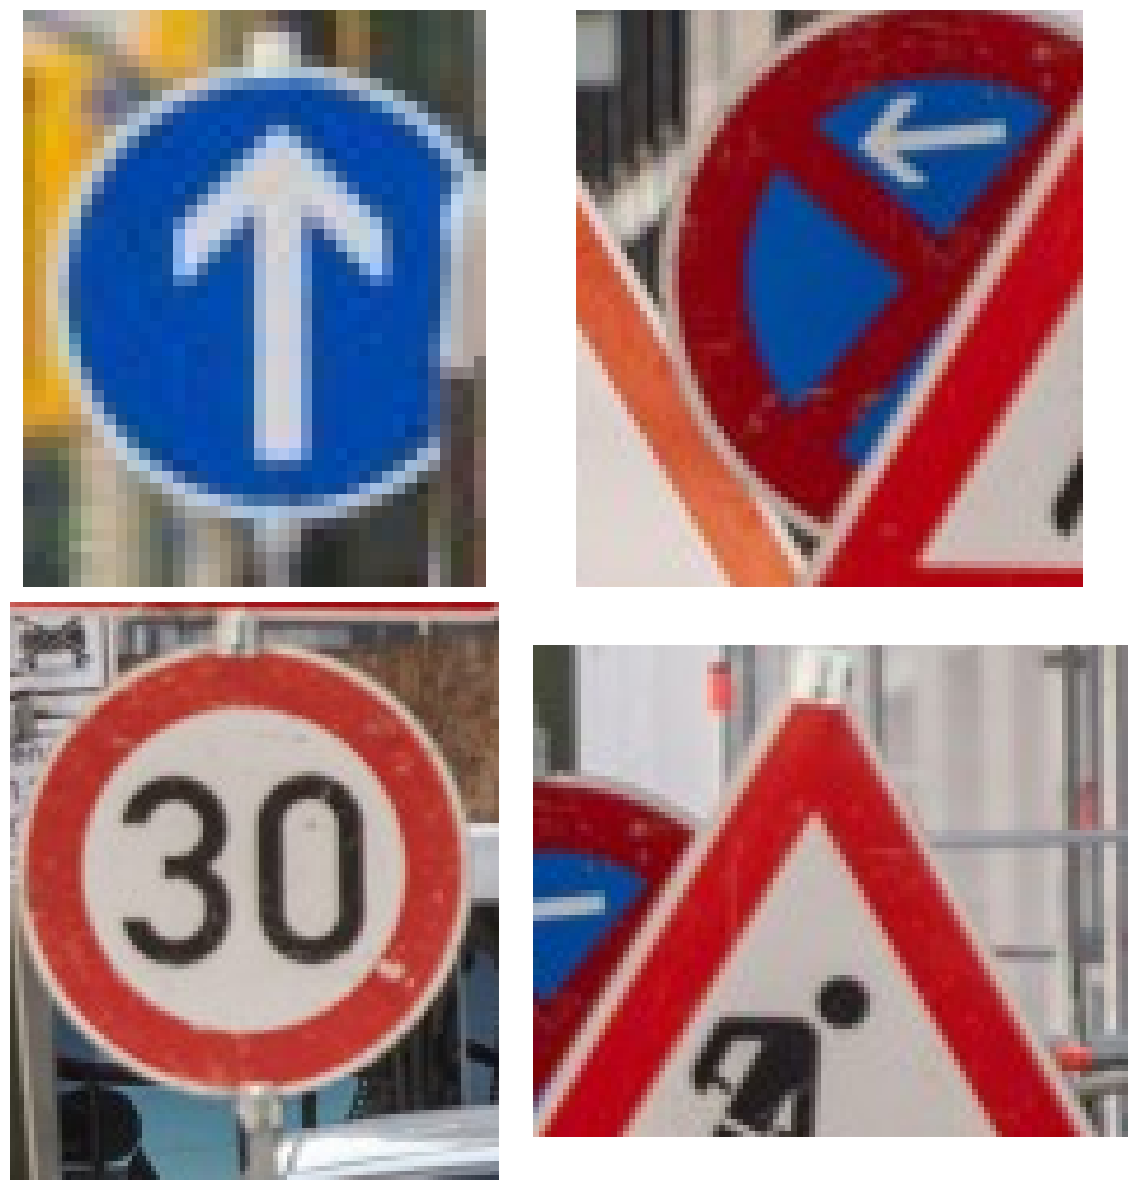

In [7]:
import matplotlib.pyplot as plt

image_array = get_cropped_images(res)

def plot_images(image_array):
    num_images = len(image_array)
    num_rows = int(num_images ** 0.5)
    num_cols = (num_images + num_rows - 1) // num_rows
    
    # Create a subplot grid
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 12))
    
    # Flatten the axes array if needed
    axes = axes.flatten()
    
    # Plot each image
    for i, ax in enumerate(axes):
        if i < num_images:
            ax.imshow(image_array[i])
            ax.axis('off')  # Turn off axis labels
        else:
            ax.axis('off')  # Turn off unused subplots
    
    # Show the plot
    plt.tight_layout()
    plt.show()
plot_images(image_array)

# Second model to detect the type of the traffic sign

In [16]:
import torch

model_traffic_sign_classification = ResNet50(img_channel=3, num_classes=43)
model_weights = os.path.join(os.getcwd(), "traffic_sign_model/best_model.pt")
model_traffic_sign_classification.load_state_dict(torch.load(model_weights))
model_traffic_sign_classification.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): block(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (identity_downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    

In [11]:
from torchvision import transforms
# Create a preprocessing pipeline
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )])

In [12]:
import csv

def load_csv_as_dict(file_path):
    result = {}

    with open(file_path, 'r') as csv_file:
        csv_reader = csv.reader(csv_file)
        next(csv_reader)  # Skip the header
        for row in csv_reader:
            if len(row) >= 2:
                result[row[0]] = row[1]

    return result

labels = load_csv_as_dict(os.path.join(os.getcwd(), "traffic_sign_model/classid_label.csv"))

In [22]:
from PIL import Image
# Test the model
path = os.path.join(dataset_dir, "test_data/test1.jpg")
img = Image.open(path).convert("RGB")
img = preprocess(img)
img = img.unsqueeze(0)
model_traffic_sign_classification.eval()
res = model_traffic_sign_classification(img)
_, index = torch.max(res, 1)
print(labels[str(int(index[0]))])

traffic circle


## YoloV8n to detect everything else

In [ ]:
# Load a model(s)
model = YOLO('yolov8n.pt')

In [ ]:
# Run batched inference on a list of images
# results get saved in runs/detect folder 
results = model.predict(images, save=True, save_txt=True)  # return a list of Results objects

In [ ]:
# plot image for debug not necessary 
i = 0
while i < len(res):
    cv2.imshow("Hi", res[i])
    key = cv2.waitKey(0)

    if key == ord("0"):
        break
    elif key == ord("1"):
        i += 1

    cv2.destroyAllWindows()

In [ ]:
# should be append by traffic sign
light_model = load_model("traffic_light_model.keras")

In [ ]:
predicted = light_model.predict(res)

In [ ]:
# Out put traffic light detection
print(predicted)
i = 0
labels = ["green", "none", "red", "yellow"]
while i < predicted.shape[0]:
    cv2.imshow(labels[np.argmax(predicted[i])], res[i])
    key = cv2.waitKey(0)

    if key == ord("0"):
        break
    elif key == ord("1"):
        i += 1

    cv2.destroyAllWindows()

## Traffic light detection - specific

# Everything together

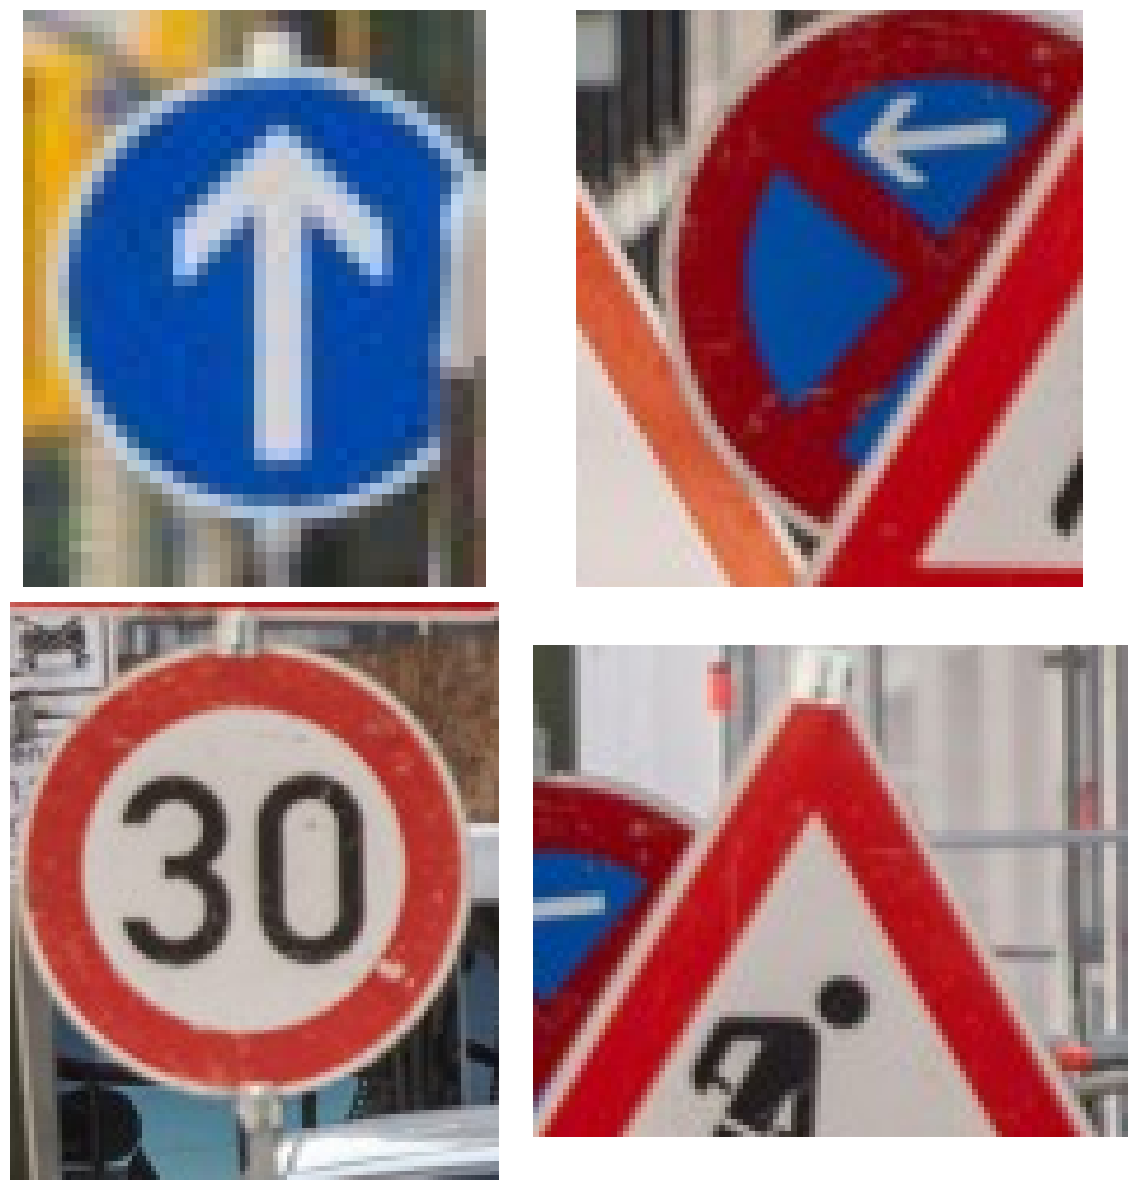

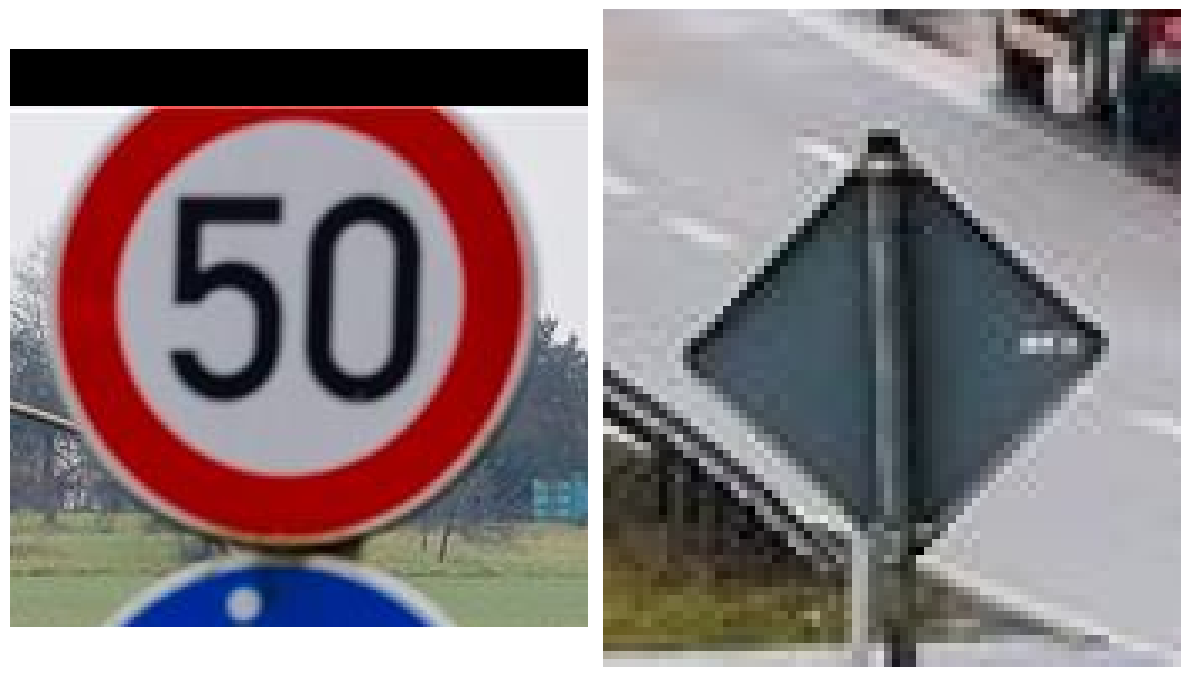

{0: {'traffic signs': ['traffic circle', '80 km/h', 'traffic circle', '120 km/h'], 'traffic lights': [], 'other objects': []}, 1: {'traffic signs': ['120 km/h', 'give way'], 'traffic lights': [], 'other objects': []}}


In [25]:
results = {}
for image_index, image in enumerate(image_paths):
    results[image_index] = {"traffic signs": [], "traffic lights": [], "other objects": []}
    # Detect traffic signs
    res = model_traffic_sign_detection.predict(image, confidence=40, overlap=30).json()
    if len(res['predictions']) != 0:
        # Detect traffic sign type
        # ToDo: Accuracy is pretty low
        cropped_images = get_cropped_images(res)
        plot_images(cropped_images)
        for image in cropped_images:
            img = preprocess(image)
            img = img.unsqueeze(0)
            res = model_traffic_sign_classification(img)
            _, index = torch.max(res, 1)
            results[image_index]["traffic signs"].append(labels[str(int(index[0]))])
    # Detect other objects
    # if there is a trafficlight
        # Detect traffic light type  
print(results)

# Print the results

In [ ]:
# plot
# print

# Some statistics